# DES Y6 Deep Field Exposures:  u-band Photometric Zeropoints tied to GALEX + GaiaEDR3 (QA)

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import glob
import math
import os
import subprocess
import sys
import gc

import glob

import fitsio
from astropy.io import fits
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack

import tempfile

import matplotlib.pyplot as plt
 
%matplotlib inline

In [2]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## 2. User Input

### 2.1.  General User Input  

In [3]:
verbose = 1
tag_des = 'Y6A2_FINALCUT'      # Official tag for DES Y6A2_FINALCUT
tag_decade = 'DECADE_FINALCUT' # Tag for DECADE
rawdata_dir = '../RawData'
zeropoints_dir='../Zeropoints'
qa_dir = '../QA'
qaFileBaseName = 'qaPlot.ZPs.galex_gaiaedr3_to_des'
bandList = ['u']

### 2.2. Logical Variables to Indicate which Code Cells to Run

In [4]:
do_qa_galex_gaiaedr3_zps = True

### 2.3. Check on Location of TMPDIR...

In [5]:
# Check on TMPDIR... 
tempfile.gettempdir()

'/data/des40.a/data/dtucker/TmpDir'

In [6]:
# Set tmpdir variable to $TMPDIR (for future reference)...
tmpdir = os.environ['TMPDIR']

### 2.4. Create Main QA Directory (if it does not already exist)...

In [7]:
# Create main QA directory, if it does not already exist...
if not os.path.exists(qa_dir):
    os.makedirs(qa_dir)

## 3. Useful Modules

In [8]:
def galexGaiaEDR3QAPlots(df_zp_band, band, subdir, qaFileBaseName):

    # Create name for output file...
    outputFileName = """%s.%s.%s.png""" % (qaFileBaseName, subdir, band)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    # Prepare QA plots...
    #fig = plt.figure(figsize=(20,10))
    fig = plt.figure(figsize=(30,25))
    #fig.subplots_adjust(hspace=0.3)
    #fig.subplots_adjust(hspace=0.5)
    supertitle = """Zeropoints tied to DES-transformed GALEX+GaiaEDR3 Photometry:\n%s, %s\n\n""" % (subdir, band)
    #fig.suptitle(supertitle, y = 1.05, fontsize=28, fontweight='bold')
    fig.suptitle(supertitle, fontsize=28, fontweight='bold')
    plt.rcParams.update({'font.size': 18})
    cmap_scale = 'rainbow'
    
    # Mask out extreme outliers (for plots)...
    mask =  ( (df_zp_band['MAG_ZERO_MEAN_SCALED'] >= 10.)  & (df_zp_band['MAG_ZERO_MEAN_SCALED'] < 40.) )
    mask &= ( (df_zp_band['AIRMASS'] >= 0.)  & (df_zp_band['AIRMASS'] < 5.) )
    mask &= ( (~df_zp_band['MAG_ZERO_MEAN_ERR'].isnull()) & (df_zp_band['MAG_ZERO_MEAN_ERR'] < 0.05) )
    mask &= (df_zp_band['MAG_ZERO_NUM'] >= 1) 

    # For simplicity, use "df1" for the masked "df_zp_band"...
    df1 = df_zp_band[mask]

    # Create individual pandas Series for the various columns in df1...
    filename = df1['FILENAME']
    expnum = df1['EXPNUM']
    ccdnum = df1['CCDNUM']
    zp = df1['MAG_ZERO_MEAN']
    zp_scaled = df1['MAG_ZERO_MEAN_SCALED']
    zperr = 1000.*df1['MAG_ZERO_MEAN_ERR']
    zpnum = df1['MAG_ZERO_NUM']
    airmass = df1['AIRMASS']
    exptime = df1['EXPTIME']
    ra_cent = df1['RA_CENT']
    dec_cent = df1['DEC_CENT']
    mjd_obs = df1['MJD_OBS']
    
    # Calculate the median value for certain values...
    zp_scaled_median = zp_scaled.median()
    zperr_median = zperr.median()
    zpnum_median = zpnum.median()
    
                            
    # Plot 1:  1d histogram of ZP (scaled)...
    plt.subplot(4,4,1)
    plotText = """median=%.4g""" % (zp_scaled_median)
    plt.hist(zp_scaled, bins=50, color='grey', alpha=0.2, label=plotText)
    plt.legend(fontsize=12, framealpha=0.5)
    plt.xlabel('ZP (scaled) [mag]')
    plt.ylabel('Number')
    plt.grid(True)

    # Plot 2:  1d histogram of ZP errors...
    plt.subplot(4,4,2)
    plotText = """median=%.4g""" % (zperr_median)
    plt.hist(zperr, bins=50, color='grey', alpha=0.2, label=plotText)
    plt.legend(fontsize=12, framealpha=0.5)
    plt.xlabel('ZP_rms [millimag]')
    plt.ylabel('Number')
    plt.grid(True)
 
    # Plot 3:  1d histogram of ZP numbers...
    plt.subplot(4,4,3)
    plotText = """median=%.4g""" % (zpnum_median)
    plt.hist(zpnum, bins=25, color='grey', alpha=0.2, label=plotText)
    plt.legend(fontsize=12, framealpha=0.5)
    plt.xlabel('ZP_num')
    plt.ylabel('Number')
    plt.grid(True)
    
    # Plot 4:  Scatter plot:  RA vs. DEC...
    plt.subplot(4,4,4)
    plt.scatter(ra_cent, dec_cent, c=zp_scaled, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='zp_scaled')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.grid(True)

    # Plot 5:  Scatter plot:  zp_scaled vs. mjd_obs...
    plt.subplot(4,4,5)
    plt.scatter(mjd_obs, zp_scaled, c=airmass, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='airmass')
    plt.xlabel('MJD [days]')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 7:  Scatter plot:  zp_scaled vs. mjd_obs...
    plt.subplot(4,4,6)
    plt.scatter(mjd_obs, zp_scaled, c=ccdnum, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='ccdnum')
    plt.xlabel('MJD [days]')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)
   
    # Plot 7:  Scatter plot:  zp_scaled vs. mjd_obs...
    plt.subplot(4,4,7)
    plt.scatter(mjd_obs, zp_scaled, c=exptime, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='exptime')
    plt.xlabel('MJD [days]')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 9:  Scatter plot:  zp_scaled vs. airmass...
    plt.subplot(4,4,9)
    plt.scatter(airmass, zp_scaled, c=mjd_obs, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='MJD [days]')
    plt.xlabel('airmass')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 10:  Scatter plot:  zp_scaled vs. airmass...
    plt.subplot(4,4,10)
    plt.scatter(airmass, zp_scaled, c=ccdnum, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='ccdnum')
    plt.xlabel('airmass')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)
   
    # Plot 11:  Scatter plot:  zp_scaled vs. airmass...
    plt.subplot(4,4,11)
    plt.scatter(airmass, zp_scaled, c=exptime, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='exptime')
    plt.xlabel('airmass')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 13:  Scatter plot:  zp_scaled vs. ccdnum...
    plt.subplot(4,4,13)
    plt.scatter(ccdnum, zp_scaled, c=mjd_obs, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='MJD [days]')
    plt.xlabel('ccdnum')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 14:  Scatter plot:  zp_scaled vs. ccdnum...
    plt.subplot(4,4,14)
    plt.scatter(ccdnum, zp_scaled, c=airmass, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='airmass')
    plt.xlabel('ccdnum')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)
   
    # Plot 15:  Scatter plot:  zp_scaled vs. ccdnum...
    plt.subplot(4,4,15)
    plt.scatter(ccdnum, zp_scaled, c=exptime, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='exptime')
    plt.xlabel('ccdnum')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    
    # Plot...
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()
    plt.savefig(outputFileName)

    return 0

In [9]:
def galexGaiaEDR3QAPlotsCombined(df_zp_band, band, qaFileBaseName):

    # Create name for output file...
    outputFileName = """%s.combined.%s.png""" % (qaFileBaseName, band)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName
            
    # Prepare QA plots...
    #fig = plt.figure(figsize=(20,10))
    fig = plt.figure(figsize=(30,25))
    #fig.subplots_adjust(hspace=0.3)
    #fig.subplots_adjust(hspace=0.5)
    supertitle = """Zeropoints tied to DES-transformed GALEX+GaiaEDR3 Photometry:\nCombined DES & DECADE, %s\n\n""" % (band)
    #supertitle = """ZEROPOINTS:  Combined DES & DECADE, %s\n\n""" % (band)
    #fig.suptitle(supertitle, y = 1.05, fontsize=28, fontweight='bold')
    fig.suptitle(supertitle, fontsize=28, fontweight='bold')
    plt.rcParams.update({'font.size': 18})
    cmap_scale = 'rainbow'
    
    # Mask out extreme outliers (for plots)...
    mask =  ( (df_zp_band['MAG_ZERO_MEAN_SCALED'] >= 10.)  & (df_zp_band['MAG_ZERO_MEAN_SCALED'] < 40.) )
    mask &= ( (df_zp_band['AIRMASS'] >= 0.)  & (df_zp_band['AIRMASS'] < 5.) )
    mask &= ( (~df_zp_band['MAG_ZERO_MEAN_ERR'].isnull()) & (df_zp_band['MAG_ZERO_MEAN_ERR'] < 0.05) )
    mask &= (df_zp_band['MAG_ZERO_NUM'] >= 1) 

    # For simplicity, use "df1" for the masked "df_zp_band"...
    df1 = df_zp_band[mask]

    # Create individual pandas Series for the various columns in df1...
    filename = df1['FILENAME']
    expnum = df1['EXPNUM']
    ccdnum = df1['CCDNUM']
    zp = df1['MAG_ZERO_MEAN']
    zp_scaled = df1['MAG_ZERO_MEAN_SCALED']
    zperr = 1000.*df1['MAG_ZERO_MEAN_ERR']
    zpnum = df1['MAG_ZERO_NUM']
    airmass = df1['AIRMASS']
    exptime = df1['EXPTIME']
    ra_cent = df1['RA_CENT']
    dec_cent = df1['DEC_CENT']
    mjd_obs = df1['MJD_OBS']

    # Create separate masks for images in the DES and in the DECADE databases...
    mask_des = (df1.DATABASE == 'DES')
    mask_decade = (df1.DATABASE == 'DECADE')
    
    # Calculate the median value for certain values...
    zp_scaled_median = zp_scaled.median()
    zperr_median = zperr.median()
    zpnum_median = zpnum.median()

    zp_scaled_median_des = df1[mask_des].MAG_ZERO_MEAN_SCALED.median()
    zperr_median_des = 1000.*df1[mask_des].MAG_ZERO_MEAN_ERR.median()
    zpnum_median_des = df1[mask_des].MAG_ZERO_NUM.median()

    zp_scaled_median_decade = df1[mask_decade].MAG_ZERO_MEAN_SCALED.median()
    zperr_median_decade = 1000.*df1[mask_decade].MAG_ZERO_MEAN_ERR.median()
    zpnum_median_decade = df1[mask_decade].MAG_ZERO_NUM.median()
    
                               
    # Plot 1:  1d histogram of ZP (scaled)...
    plt.subplot(4,4,1)
    plotText = """COMBINED:  median=%.4g""" % (zp_scaled_median)
    plt.hist(df1.MAG_ZERO_MEAN_SCALED, bins=50, color='grey', alpha=0.2, label=plotText)
    plotText = """DES:  median=%.4g""" % (zp_scaled_median_des)
    plt.hist(df1[mask_des].MAG_ZERO_MEAN_SCALED, histtype='step', bins=50, color='blue', alpha=0.5, label=plotText)
    plotText = """DECADE:  median=%.4g""" % (zp_scaled_median_decade)
    plt.hist(df1[mask_decade].MAG_ZERO_MEAN_SCALED, histtype='step', bins=50, color='red', alpha=0.5, label=plotText)
    plt.legend(fontsize=12, framealpha=0.5)
    plt.xlabel('ZP (scaled) [mag]')
    plt.ylabel('Number')
    plt.grid(True)

    # Plot 2:  1d histogram of ZP errors...
    plt.subplot(4,4,2)
    plotText = """COMBINED:  median=%.4g""" % (zperr_median)
    plt.hist(1000.*df1.MAG_ZERO_MEAN_ERR, bins=50, color='grey', alpha=0.2, label=plotText)
    plotText = """DES:  median=%.4g""" % (zperr_median_des)
    plt.hist(1000.*df1[mask_des].MAG_ZERO_MEAN_ERR, histtype='step', bins=50, color='blue', alpha=0.5, label=plotText)
    plotText = """DECADE:  median=%.4g""" % (zperr_median_decade)
    plt.hist(1000.*df1[mask_decade].MAG_ZERO_MEAN_ERR, histtype='step', bins=50, color='red', alpha=0.5, label=plotText)
    plt.legend(fontsize=12, framealpha=0.5)
    plt.xlabel('ZP_rms [millimag]')
    plt.ylabel('Number')
    plt.grid(True)
    
    # Plot 3:  1d histogram of ZP numbers...    
    plt.subplot(4,4,3)
    plotText = """COMBINED:  median=%.4g""" % (zpnum_median)
    plt.hist(df1.MAG_ZERO_NUM, bins=25, color='grey', alpha=0.2, label=plotText)
    plotText = """DES:  median=%.4g""" % (zpnum_median_des)
    plt.hist(df1[mask_des].MAG_ZERO_NUM, histtype='step', bins=25, color='blue', alpha=0.5, label=plotText)
    plotText = """DECADE:  median=%.4g""" % (zpnum_median_decade)
    plt.hist(df1[mask_decade].MAG_ZERO_NUM, histtype='step', bins=25, color='red', alpha=0.5, label=plotText)
    plt.legend(fontsize=12, framealpha=0.5)
    plt.xlabel('ZP_num')
    plt.ylabel('Number')
    plt.grid(True)

    # Plot 4:  Scatter plot:  RA vs. DEC...
    plt.subplot(4,4,4)
    plt.scatter(ra_cent, dec_cent, c=zp_scaled, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='zp_scaled')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.grid(True)
        
    # Plot 5:  Scatter plot:  zp_scaled vs. mjd_obs...
    plt.subplot(4,4,5)
    plt.scatter(mjd_obs, zp_scaled, c=airmass, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='airmass')
    plt.xlabel('MJD [days]')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 6:  Scatter plot:  zp_scaled vs. mjd_obs...
    plt.subplot(4,4,6)
    plt.scatter(mjd_obs, zp_scaled, c=ccdnum, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='ccdnum')
    plt.xlabel('MJD [days]')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)   
    
    # Plot 7:  Scatter plot:  zp_scaled vs. mjd_obs...
    plt.subplot(4,4,7)
    plt.scatter(mjd_obs, zp_scaled, c=exptime, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='exptime')
    plt.xlabel('MJD [days]')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 8:  Scatter plot:  zp_scaled vs. mjd_obs...
    plt.subplot(4,4,8)
    plt.scatter(df1[mask_des].MJD_OBS, 
                df1[mask_des].MAG_ZERO_MEAN_SCALED, 
                color='blue', label='DES', alpha=0.2)
    plt.scatter(df1[mask_decade].MJD_OBS, 
                df1[mask_decade].MAG_ZERO_MEAN_SCALED, 
                color='red', label='DECADE', alpha=0.2)
    plt.legend(framealpha=0.5)
    plt.xlabel('MJD [days]')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 9:  Scatter plot:  zp_scaled vs. airmass...
    plt.subplot(4,4,9)
    plt.scatter(airmass, zp_scaled, c=mjd_obs, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='MJD [days]')
    plt.xlabel('airmass')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 10:  Scatter plot:  zp_scaled vs. airmass...
    plt.subplot(4,4,10)
    plt.scatter(airmass, zp_scaled, c=ccdnum, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='ccdnum')
    plt.xlabel('airmass')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)
   
    # Plot 11:  Scatter plot:  zp_scaled vs. airmass...
    plt.subplot(4,4,11)
    plt.scatter(airmass, zp_scaled, c=exptime, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='exptime')
    plt.xlabel('airmass')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 12:  Scatter plot:  zp_scaled vs. airmass...
    plt.subplot(4,4,12)
    plt.scatter(df1[mask_des].AIRMASS, 
                df1[mask_des].MAG_ZERO_MEAN_SCALED, 
                color='blue', label='DES', alpha=0.2)
    plt.scatter(df1[mask_decade].AIRMASS, 
                df1[mask_decade].MAG_ZERO_MEAN_SCALED, 
                color='red', label='DECADE', alpha=0.2)
    plt.legend(framealpha=0.5)
    plt.xlabel('airmass')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 13:  Scatter plot:  zp_scaled vs. ccdnum...
    plt.subplot(4,4,13)
    plt.scatter(ccdnum, zp_scaled, c=mjd_obs, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='MJD [days]')
    plt.xlabel('ccdnum')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)
    
    # Plot 14:  Scatter plot:  zp_scaled vs. ccdnum...
    plt.subplot(4,4,14)
    plt.scatter(ccdnum, zp_scaled, c=airmass, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='airmass')
    plt.xlabel('ccdnum')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)
    
    # Plot 15:  Scatter plot:  zp_scaled vs. ccdnum...
    plt.subplot(4,4,15)
    plt.scatter(ccdnum, zp_scaled, c=exptime, cmap=cmap_scale, alpha=0.2)
    plt.colorbar(label='exptime')
    plt.xlabel('ccdnum')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)

    # Plot 16:  Scatter plot:  zp_scaled vs. ccdnum...
    plt.subplot(4,4,16)
    plt.scatter(df1[mask_des].CCDNUM, 
                df1[mask_des].MAG_ZERO_MEAN_SCALED, 
                color='blue', label='DES', alpha=0.2)
    plt.scatter(df1[mask_decade].CCDNUM, 
                df1[mask_decade].MAG_ZERO_MEAN_SCALED, 
                color='red', label='DECADE', alpha=0.2)
    plt.legend(framealpha=0.5)
    plt.xlabel('ccdnum')
    plt.ylabel('ZP (scaled) [mag]')
    plt.grid(True)
    
 
    # Plot...
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()
    plt.savefig(outputFileName)

    
    return 0

## 4. Read in Zeropoint Tables

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

In [10]:
if do_qa_galex_gaiaedr3_zps:
        
    subdir = """DES_%s""" % (tag_des)
    tmpdir = os.environ['TMPDIR']
    
    df_zp_collection = {}

    for band in bandList:
        
        zpFile = """zps_%s.%s.galex.gaiaedr3.csv""" % (subdir, band)
        zpFile = os.path.join(zeropoints_dir, zpFile)
        df_zp = pd.read_csv(zpFile, usecols=['FILENAME','EXPNUM_MEDIAN','CCDNUM_MEDIAN',
                                         'MAG_ZERO_MEAN','MAG_ZERO_MEAN_ERR','MAG_ZERO_NUM',
                                         'AIRMASS_MEDIAN','EXPTIME_MEDIAN',
                                         'RA_CENT_MEDIAN','DEC_CENT_MEDIAN','MJD_OBS_MEDIAN'])

        # Rename '_MEDIAN' columns...
        #  (The '_MEDIAN' suffix is a 'feature' of how the zeropoints table was created.)
        df_zp.rename(columns={'EXPNUM_MEDIAN':'EXPNUM',
                              'CCDNUM_MEDIAN':'CCDNUM',
                              'AIRMASS_MEDIAN':'AIRMASS', 
                              'EXPTIME_MEDIAN':'EXPTIME', 
                              'RA_CENT_MEDIAN':'RA_CENT', 
                              'DEC_CENT_MEDIAN':'DEC_CENT',
                              'MJD_OBS_MEDIAN':'MJD_OBS'
                            },inplace=True)

        # Likewise, convert EXPNUM, CCDNUM, and MAG_ZERO_NUM from floats to ints...
        #  (Again, a 'feature' of how the zeropoints table was created.)
        df_zp['EXPNUM'] = df_zp['EXPNUM'].astype(int)
        df_zp['CCDNUM'] = df_zp['CCDNUM'].astype(int)
        df_zp['MAG_ZERO_NUM'] = df_zp['MAG_ZERO_NUM'].astype(int)

        # Add a exptime-scaled versions of MAG_ZERO_MEAN...
        df_zp['MAG_ZERO_MEAN_SCALED'] = df_zp['MAG_ZERO_MEAN'] - 2.5*np.log10(df_zp['EXPTIME'])

        # Add df_zp the df_zp_collection_des dictionary...
        df_zp_collection[band] = df_zp

    # df_zp_collection specifically for the DES data...
    df_zp_collection_des = df_zp_collection

In [11]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_des['u']
df_zp.head(5)

,FILENAME,EXPNUM,EXPTIME,AIRMASS,MJD_OBS,CCDNUM,RA_CENT,DEC_CENT,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MAG_ZERO_MEAN_SCALED
0,D00709785_u_c01_r3518p01_red-fullcat.fits,709785,360.0,1.3,58124.081,1,36.9130,1.8059,30.4273,0.0455,8,24.036544
1,D00709785_u_c03_r3518p01_red-fullcat.fits,709785,360.0,1.3,58124.081,3,37.5344,1.8058,30.3675,0.0217,12,23.976744
2,D00709785_u_c04_r3518p01_red-fullcat.fits,709785,360.0,1.3,58124.081,4,36.7576,1.6418,30.3530,0.0219,13,23.962244
3,D00709785_u_c05_r3518p01_red-fullcat.fits,709785,360.0,1.3,58124.081,5,37.0683,1.6422,30.3555,0.0090,6,23.964744
4,D00709785_u_c06_r3518p01_red-fullcat.fits,709785,360.0,1.3,58124.081,6,37.3792,1.6421,30.4142,0.0166,13,24.023444


**DECADE:**

In [12]:
if do_qa_galex_gaiaedr3_zps:
        
    subdir = """%s""" % (tag_decade)
    tmpdir = os.environ['TMPDIR']
    
    df_zp_collection = {}

    for band in bandList:
        
        zpFile = """zps_%s.%s.galex.gaiaedr3.csv""" % (subdir, band)
        zpFile = os.path.join(zeropoints_dir, zpFile)
        df_zp = pd.read_csv(zpFile, usecols=['FILENAME','EXPNUM_MEDIAN','CCDNUM_MEDIAN',
                                         'MAG_ZERO_MEAN','MAG_ZERO_MEAN_ERR','MAG_ZERO_NUM',
                                         'AIRMASS_MEDIAN','EXPTIME_MEDIAN',
                                         'RA_CENT_MEDIAN','DEC_CENT_MEDIAN','MJD_OBS_MEDIAN'])

        # Rename '_MEDIAN' columns...
        #  (The '_MEDIAN' suffix is a 'feature' of how the zeropoints table was created.)
        df_zp.rename(columns={'EXPNUM_MEDIAN':'EXPNUM',
                              'CCDNUM_MEDIAN':'CCDNUM',
                              'AIRMASS_MEDIAN':'AIRMASS', 
                              'EXPTIME_MEDIAN':'EXPTIME', 
                              'RA_CENT_MEDIAN':'RA_CENT', 
                              'DEC_CENT_MEDIAN':'DEC_CENT',
                              'MJD_OBS_MEDIAN':'MJD_OBS'
                            },inplace=True)

        # Likewise, convert EXPNUM, CCDNUM, and MAG_ZERO_NUM from floats to ints...
        #  (Again, a 'feature' of how the zeropoints table was created.)
        df_zp['EXPNUM'] = df_zp['EXPNUM'].astype(int)
        df_zp['CCDNUM'] = df_zp['CCDNUM'].astype(int)
        df_zp['MAG_ZERO_NUM'] = df_zp['MAG_ZERO_NUM'].astype(int)

        # Add a exptime-scaled versions of MAG_ZERO_MEAN...
        df_zp['MAG_ZERO_MEAN_SCALED'] = df_zp['MAG_ZERO_MEAN'] - 2.5*np.log10(df_zp['EXPTIME'])

        # Add df_zp the df_zp_collection_des dictionary...
        df_zp_collection[band] = df_zp

    # df_zp_collection specifically for the DECADE data...
    df_zp_collection_decade = df_zp_collection

In [13]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_decade['u']
df_zp.head(5)

,FILENAME,EXPNUM,EXPTIME,AIRMASS,MJD_OBS,CCDNUM,RA_CENT,DEC_CENT,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MAG_ZERO_MEAN_SCALED
0,D00945150_u_c01_r5153p02_red-fullcat.fits,945150,300.0,1.06,59135.275,1,60.4291,-46.8482,30.4360,0.0153,18,24.243197
1,D00945150_u_c03_r5153p02_red-fullcat.fits,945150,300.0,1.06,59135.275,3,61.3372,-46.8477,30.4922,0.0299,9,24.299397
2,D00945150_u_c04_r5153p02_red-fullcat.fits,945150,300.0,1.06,59135.275,4,60.2000,-47.0113,30.4536,0.0264,8,24.260797
3,D00945150_u_c05_r5153p02_red-fullcat.fits,945150,300.0,1.06,59135.275,5,60.6554,-47.0124,30.4741,0.0104,15,24.281297
4,D00945150_u_c06_r5153p02_red-fullcat.fits,945150,300.0,1.06,59135.275,6,61.1112,-47.0123,30.4439,0.0190,16,24.251097


## 4. Create Some QA plots for the Zeropoint Tables

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
u
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

../QA/qaPlot.ZPs.galex_gaiaedr3_to_des.DES_Y6A2_FINALCUT.u.png


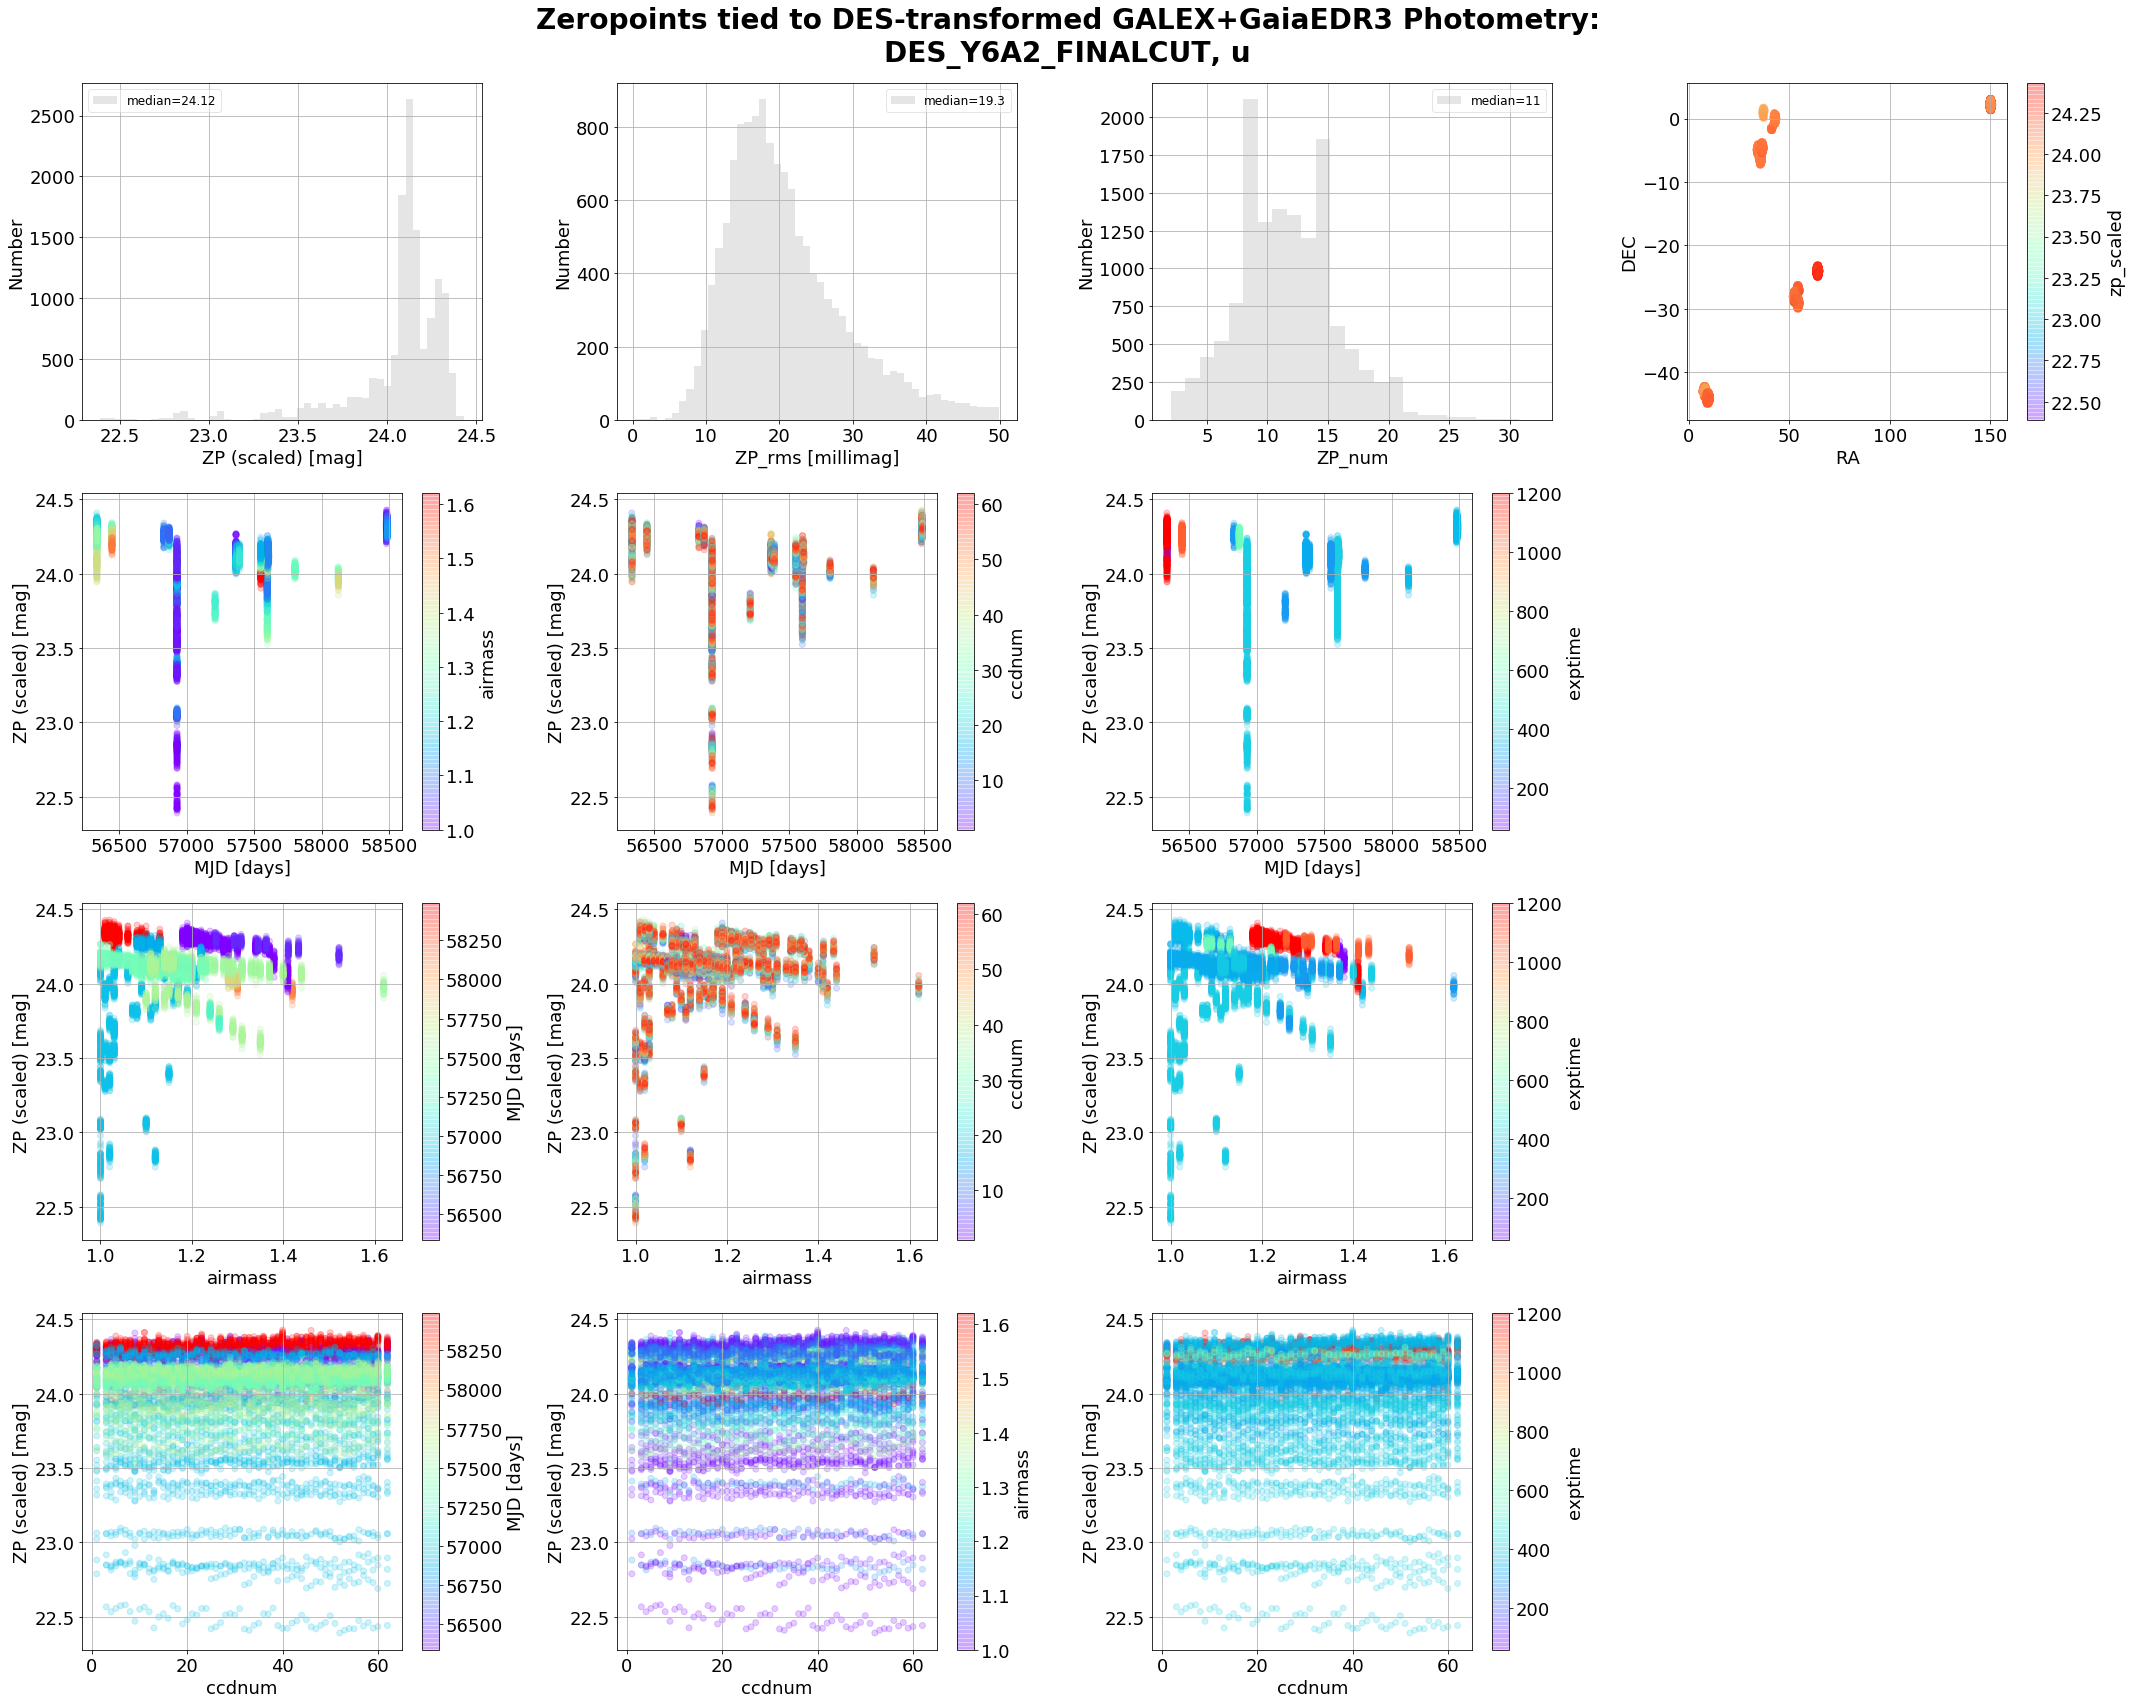

In [14]:
if do_qa_galex_gaiaedr3_zps:
        
    subdir = """DES_%s""" % (tag_des)
    tmpdir = os.environ['TMPDIR']
    df_zp_collection = df_zp_collection_des
        
    for band in bandList:

        print 
        print 
        print 
        print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
        print band
        print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
        print 

        df_zp_band = df_zp_collection[band]

        status = galexGaiaEDR3QAPlots(df_zp_band, band, subdir, qaFileBaseName)


**DECADE:**




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
u
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

../QA/qaPlot.ZPs.galex_gaiaedr3_to_des.DECADE_FINALCUT.u.png


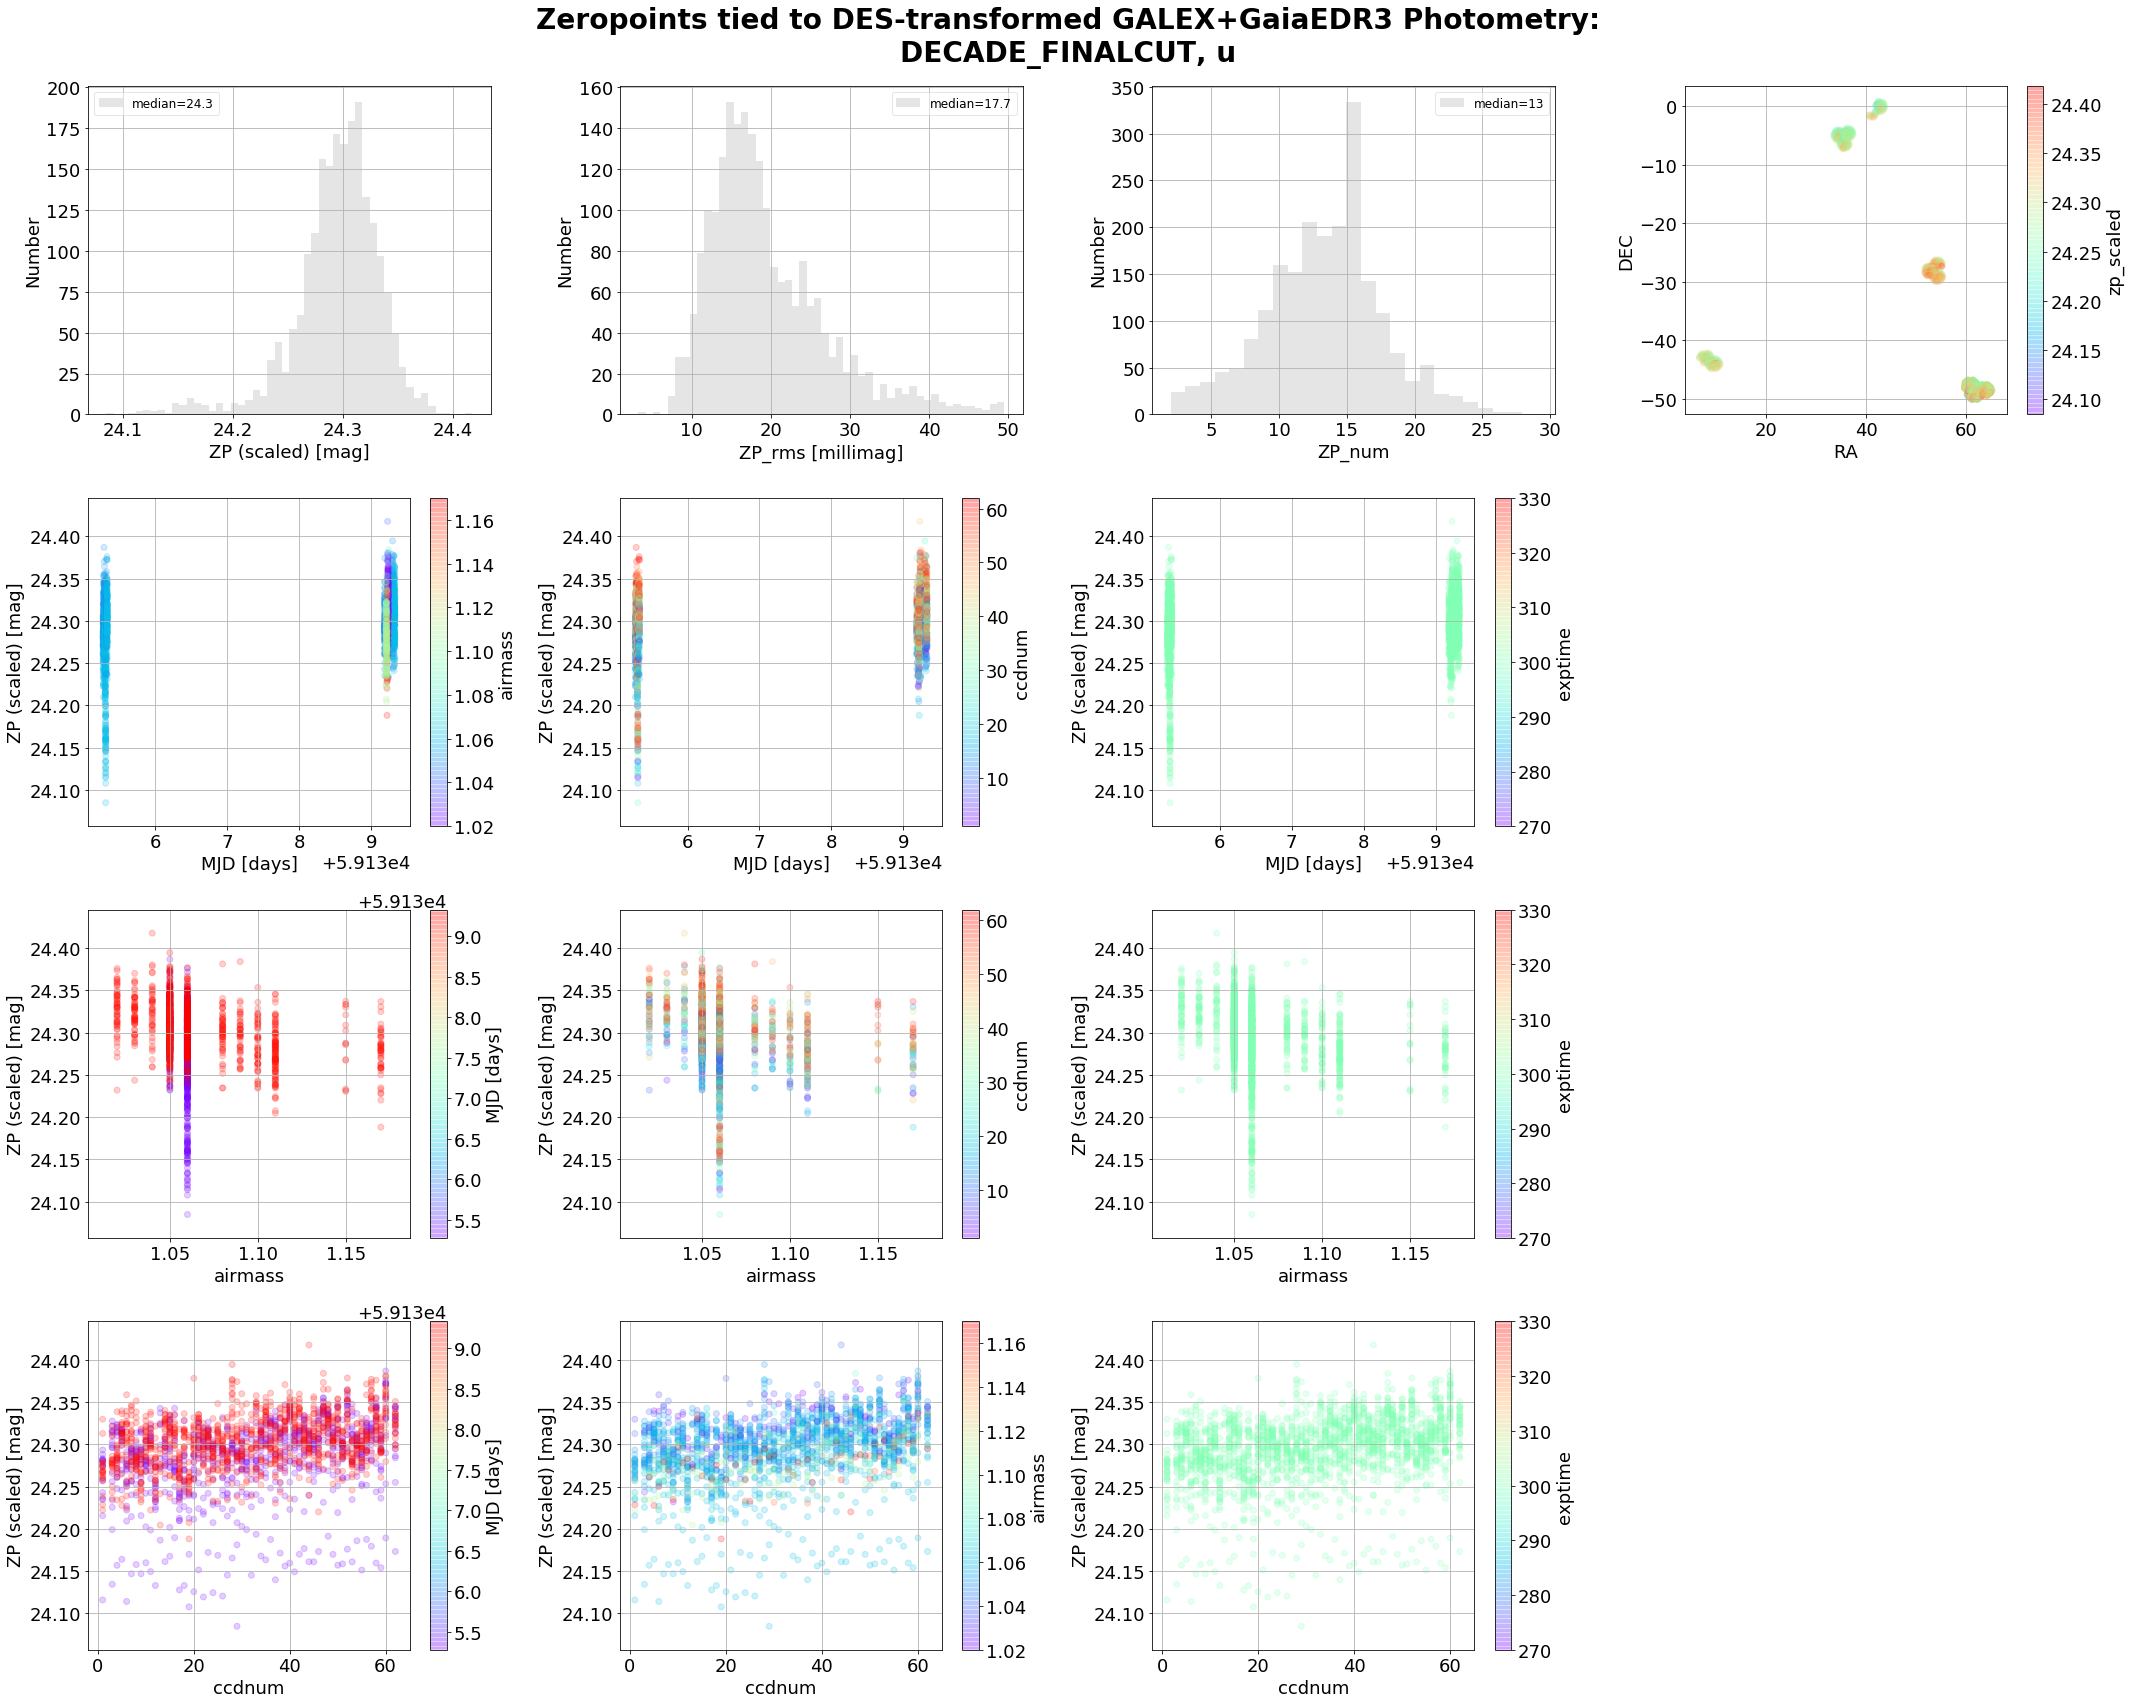

In [15]:
if do_qa_galex_gaiaedr3_zps:
        
    subdir = """%s""" % (tag_decade)
    tmpdir = os.environ['TMPDIR']
    df_zp_collection = df_zp_collection_decade
        
    for band in bandList:

        print 
        print 
        print 
        print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
        print band
        print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
        print 

        df_zp_band = df_zp_collection[band]
        
        status = galexGaiaEDR3QAPlots(df_zp_band, band, subdir, qaFileBaseName)


**Combined DES and DECADE:**




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
u
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

187252
28184
215436
../QA/qaPlot.ZPs.galex_gaiaedr3_to_des.combined.u.png


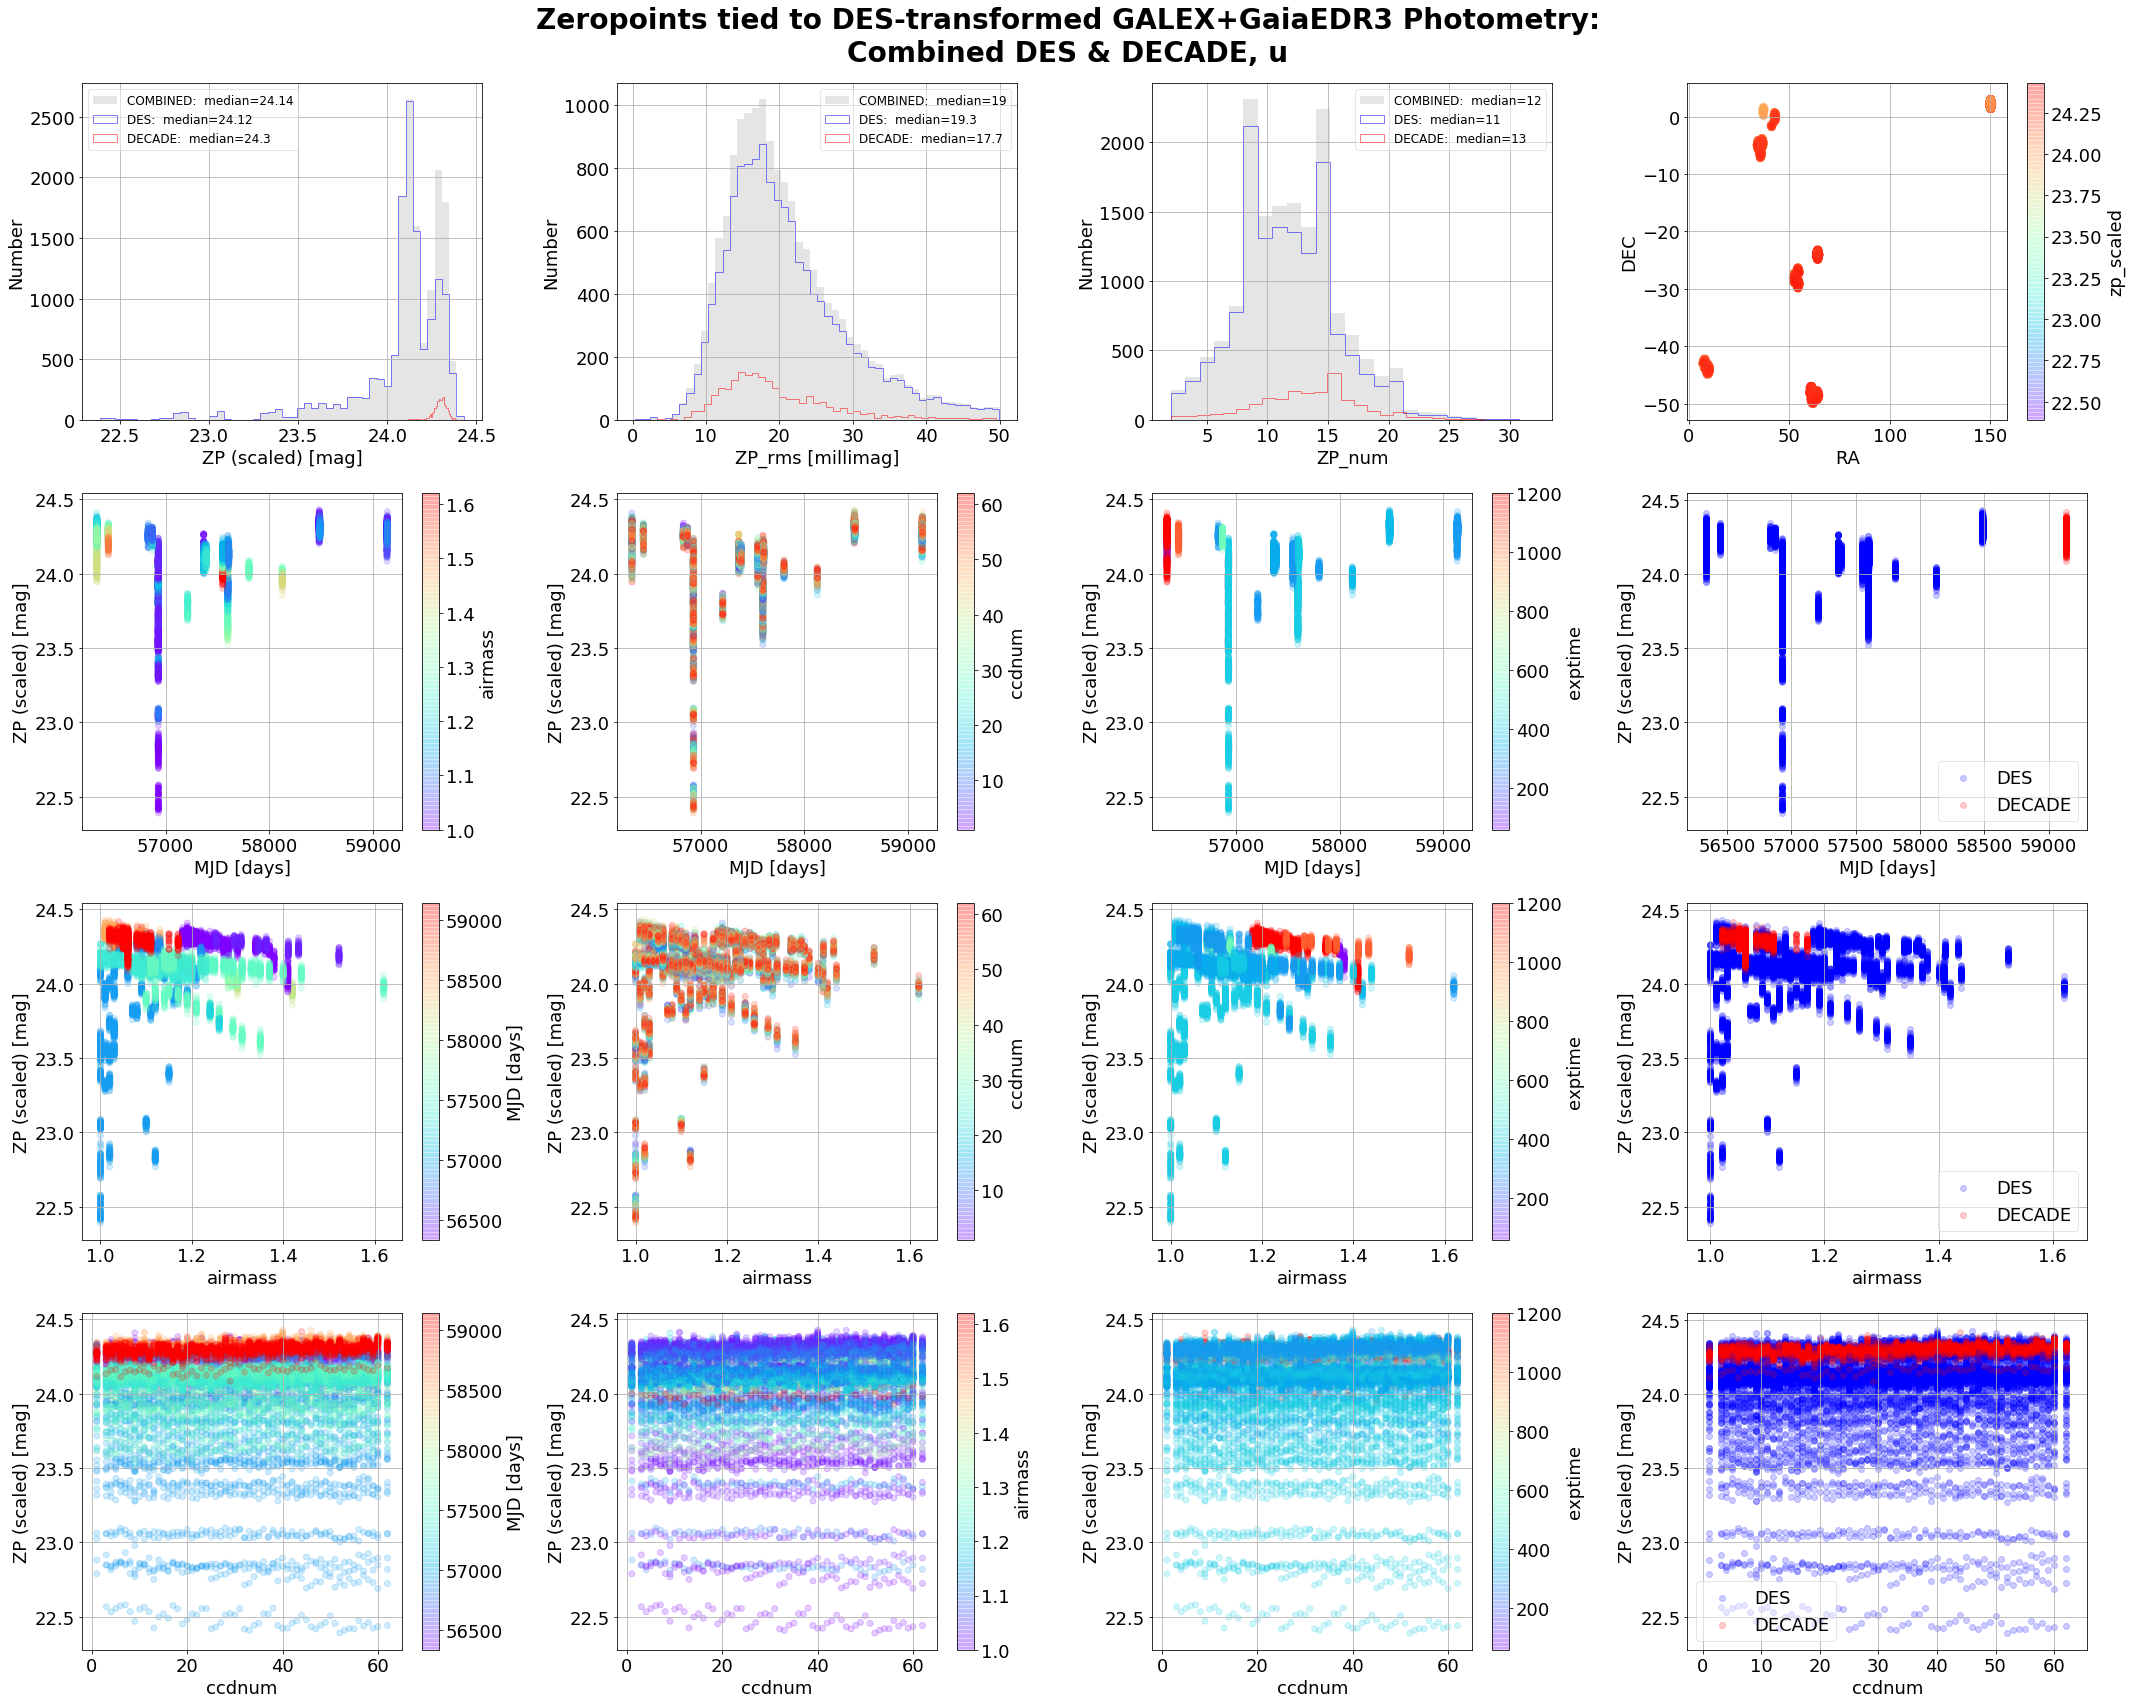

In [16]:
if do_qa_galex_gaiaedr3_zps:
        
    tmpdir = os.environ['TMPDIR']
        
    for band in bandList:

        print 
        print 
        print 
        print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
        print band
        print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
        print 

        # Create dataframe for the combined DES and DECADE data for this band...
        df_zp_band_des = df_zp_collection_des[band].copy()
        df_zp_band_des['DATABASE'] = 'DES'
        print df_zp_band_des.size
        df_zp_band_decade = df_zp_collection_decade[band].copy()
        df_zp_band_decade['DATABASE'] = 'DECADE'
        print df_zp_band_decade.size
        df_zp_band = pd.concat([df_zp_band_des, df_zp_band_decade], ignore_index=True)
        print df_zp_band.size

        status = galexGaiaEDR3QAPlotsCombined(df_zp_band, band, qaFileBaseName)
